In [73]:
import numpy as np
import tensorflow as tf
import soundfile as sf
import resampy
import librosa
import os
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import yamnet as yamnet_model
import params as yamnet_params
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
from audiomentations import Compose, AddBackgroundNoise, TimeStretch, PitchShift, Shift, AddGaussianNoise
import random

In [74]:
def load_finetunable_yamnet():
    params = yamnet_params.Params()
    model = yamnet_model.yamnet_frames_model(params)
    model.load_weights('yamnet.h5')  # download: https://storage.googleapis.com/audioset/yamnet.h5

    for layer in model.layers[-5:]:
        layer.trainable = True
    return model


In [75]:
def augment_audio(audio, sr):
    if np.random.rand() < 0.5:
        audio = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=np.random.randint(-2, 3))
    if np.random.rand() < 0.5:
        audio = librosa.effects.time_stretch(y=audio, rate=np.random.uniform(0.8, 1.2))
    if np.random.rand() < 0.5:
        noise = 0.005 * np.random.randn(len(audio))
        audio = audio + noise
    return np.clip(audio, -1.0, 1.0)

# Set up augmentation pipeline
# augment = Compose([
#     AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
#     TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
#     PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
#     Shift(min_shift=-0.2, max_shift=0.2, p=0.5)  # ✅ Corrected here
# ])

In [76]:
def extract_features_finetuned(yamnet, audio_path, sample_rate=16000):
    # try:
        y, sr = librosa.load(audio_path, sr=sample_rate)
        y = augment_audio(y, sr)  # <—— AUGMENTED HERE

        waveform = tf.convert_to_tensor(y, dtype=tf.float32)
        waveform = tf.reshape(waveform, [-1])

        _, embeddings, _ = yamnet(waveform)
        avg_embedding = tf.reduce_mean(embeddings, axis=0).numpy()  # (1024,)

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_flat = np.mean(mel_spec_db, axis=1)  # (40,)

        return np.concatenate([avg_embedding, mel_spec_flat])  # (1064,)
    # except Exception as e:
    #     print(f"Error processing {audio_path}: {e}")
        # return None

# def extract_features_finetuned(yamnet, audio_path, sample_rate=16000, augment_audio=False):
#     try:
#         y, sr = librosa.load(audio_path, sr=sample_rate)

#         # Apply augmentation randomly
#         if augment_audio:
#             y = augment(samples=y, sample_rate=sr)

#         waveform = tf.convert_to_tensor(y, dtype=tf.float32)
#         waveform = tf.reshape(waveform, [-1])

#         _, embeddings, _ = yamnet(waveform)
#         avg_embedding = tf.reduce_mean(embeddings, axis=0).numpy()

#         mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
#         mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
#         mel_spec_flat = np.mean(mel_spec_db, axis=1)

#         return np.concatenate([avg_embedding, mel_spec_flat])
#     except Exception as e:
#         print(f"Error processing {audio_path}: {e}")
#         return None


In [77]:
def extract_features_from_folder(base_path):
    X, y = [], []
    yamnet = load_finetunable_yamnet()

    label_encoder = LabelEncoder()
    all_labels = sorted(os.listdir(base_path))  # e.g., ['child_danger', 'normal', 'woman_danger']
    label_encoder.fit(all_labels)

    for label in tqdm(all_labels, desc="Processing folders"):
        folder_path = os.path.join(base_path, label)
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                features = extract_features_finetuned(yamnet, file_path)
                # features = extract_features_finetuned(yamnet, file_path, augment_audio=True)
                if features is not None:
                    X.append(features)
                    y.append(label)

    X = np.array(X)
    y = label_encoder.transform(y)
    return X, y, label_encoder


In [78]:
X, y, label_encoder = extract_features_from_folder(r'C:\Users\Vishal Kumar Patel\Desktop\Yamnetmodelproject\data')
print("Feature shape:", X.shape)
print("Label shape:", y.shape)
print("Classes:", label_encoder.classes_) 






np.save("X_embeddings_augmented.npy", X)
np.save("y_labels_augmented.npy", y)

Processing folders: 100%|███████████████████████████████████████████████████████████████| 3/3 [23:54<00:00, 478.29s/it]


Feature shape: (13562, 1064)
Label shape: (13562,)
Classes: ['Child' 'Normal' 'Women']


In [79]:

# Load embeddings and labels from saved files
X = np.load("X_embeddings_augmented.npy")  # shape: (n_samples, 1024)
y = np.load("y_labels_augmented.npy")      # shape: (n_samples,)


In [80]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Lambda, Activation, Multiply
import tensorflow.keras.backend as K

# One-hot encode labels
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

# Reshape for BiLSTM [samples, time_steps=1, features]
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=np.argmax(y_cat, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Attention layer
# def attention_block(inputs):
#     weights = Dense(1, activation='tanh')(inputs)
#     weights = tf.nn.softmax(weights, axis=1)
#     output = tf.reduce_sum(inputs * weights, axis=1)
#     return output

def attention_block(inputs):
    # Step 1: Compute attention weights
    attention_weights = Dense(1, activation='tanh')(inputs)
    attention_weights = Activation('softmax')(attention_weights)

    # Step 2: Apply attention (weighted sum)
    weighted_input = Multiply()([inputs, attention_weights])
    context_vector = Lambda(lambda x: K.sum(x, axis=1))(weighted_input)
    
    return context_vector

# Model
input_layer = Input(shape=(1, X.shape[1]))
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = Dropout(0.3)(x)
x = attention_block(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 1, 1064)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_6               │ (None, 1, 256)            │       1,221,632 │ input_layer_6[0][0]        │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 1, 256)            │               0 │ bidirectional_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_14 (Dense)              │ (None, 1, 1)              │             257 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_4 (Activation)     │ (None, 1, 1)              │               0 │ dense_14[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_4 (Multiply)         │ (None, 1, 256)            │               0 │ dropout_10[0][0],          │
│                               │                           │                 │ activation_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_4 (Lambda)             │ (None, 256)               │               0 │ multiply_4[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_15 (Dense)              │ (None, 128)               │          32,896 │ lambda_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 128)               │               0 │ dense_15[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_16 (Dense)              │ (None, 3)                 │             387 │ dropout_11[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,255,172 (4.79 MB)

 Trainable params: 1,255,172 (4.79 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


C:\Users\Vishal Kumar Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6952 - loss: 0.6959 - val_accuracy: 0.8249 - val_loss: 0.4600
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8112 - loss: 0.4975 - val_accuracy: 0.8175 - val_loss: 0.4539
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8302 - loss: 0.4523 - val_accuracy: 0.8387 - val_loss: 0.4151
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8385 - loss: 0.4366 - val_accuracy: 0.8373 - val_loss: 0.4076
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8406 - loss: 0.4225 - val_accuracy: 0.8401 - val_loss: 0.4118
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8479 - loss: 0.3914 - val_accuracy: 0.8373 - val_loss: 0.4083
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8519 - loss: 0.3897 - val_accuracy: 0.8562 - val_loss: 0.3658
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8557 - loss: 0.3864 - val_accuracy: 0.860

In [82]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9104 - loss: 0.2411
✅ Test Accuracy: 90.93%


16/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   

C:\Users\Vishal Kumar Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


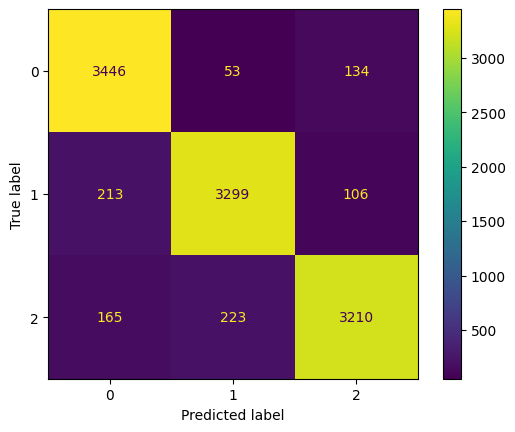

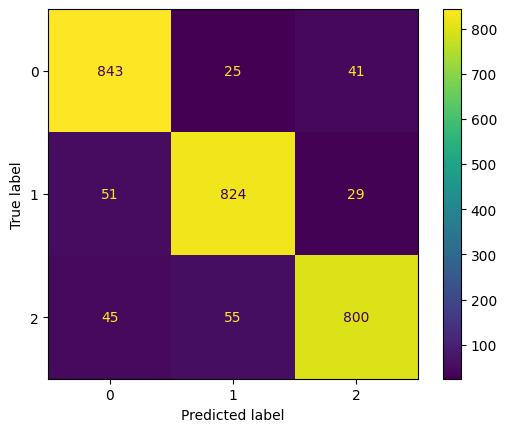

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       909
           1       0.91      0.91      0.91       904
           2       0.92      0.89      0.90       900

    accuracy                           0.91      2713
   macro avg       0.91      0.91      0.91      2713
weighted avg       0.91      0.91      0.91      2713



In [83]:
predicted_test = model.predict(X_test)
predicted_train = model.predict(X_train)
predicted_class = []
for i in range(len(predicted_train)):
  predicted_class.append(np.argmax(predicted_train[i]))
predicted_class_index = []
for i in range(len(predicted_test)):
  predicted_class_index.append(np.argmax(predicted_test[i]))
rounded_test = np.argmax(y_test,axis=1)
rounded_train = np.argmax(y_train,axis=1)


confusion_matrix = metrics.confusion_matrix(rounded_train, predicted_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()


confusion_matrix = metrics.confusion_matrix(rounded_test, predicted_class_index)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()


print(classification_report(rounded_test, predicted_class_index))



In [84]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=['woman_danger', 'child_danger', 'normal']))


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

woman_danger       0.90      0.93      0.91       909
child_danger       0.91      0.91      0.91       904
      normal       0.92      0.89      0.90       900

    accuracy                           0.91      2713
   macro avg       0.91      0.91      0.91      2713
weighted avg       0.91      0.91      0.91      2713



In [85]:
model.save('audio_classification_model1.h5')